In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

In [29]:
df = pd.read_csv("iris.csv")  
target_variable = "species"

In [30]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [31]:
le = LabelEncoder()
df[target_variable] = le.fit_transform(df[target_variable])

In [32]:
X = df.drop(columns=[target_variable]).values
y = df[target_variable].values


In [33]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [35]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [36]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)


In [37]:
class BayesianNN(nn.Module):
    def __init__(self, input_dim, output_dim, mu=0, sigma=0.5):
        super().__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=input_dim, out_features=32)
        self.fc2 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=32, out_features=16)
        self.fc3 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=16, out_features=output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, mc_dropout=False):
        x = self.relu(self.fc1(x))
        x = self.dropout(x) if mc_dropout else x
        x = self.relu(self.fc2(x))
        x = self.dropout(x) if mc_dropout else x
        return self.fc3(x)

In [38]:
# 
mu = 0
sigma = 0.3
lambda_kl = 0.1
mc_samples_eval = 30
learning_rate = 0.005
weight_decay = 0.0001

# 
model = BayesianNN(input_dim=X.shape[1], 
                  output_dim=len(np.unique(y)),
                  sigma=sigma,
                  mu=mu)


criterion = nn.CrossEntropyLoss()
bkl_loss = bnn.BKLLoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch 1/500 | Train Loss: 0.2153 | Val Loss: 0.1301 | Val Acc: 0.9333 | Uncertainty: 1.6965
Epoch 2/500 | Train Loss: 0.1520 | Val Loss: 0.1276 | Val Acc: 0.9333 | Uncertainty: 1.9252
Epoch 3/500 | Train Loss: 0.1594 | Val Loss: 0.1440 | Val Acc: 0.9333 | Uncertainty: 1.4382
Epoch 4/500 | Train Loss: 0.0943 | Val Loss: 0.1415 | Val Acc: 0.9333 | Uncertainty: 1.8324
Epoch 5/500 | Train Loss: 0.1261 | Val Loss: 0.1512 | Val Acc: 0.9333 | Uncertainty: 1.9137
Epoch 6/500 | Train Loss: 0.1391 | Val Loss: 0.1510 | Val Acc: 0.9333 | Uncertainty: 1.9612
Epoch 7/500 | Train Loss: 0.1565 | Val Loss: 0.1477 | Val Acc: 0.8667 | Uncertainty: 1.6425
Epoch 8/500 | Train Loss: 0.1253 | Val Loss: 0.1493 | Val Acc: 0.9333 | Uncertainty: 1.8435
Epoch 9/500 | Train Loss: 0.1819 | Val Loss: 0.1575 | Val Acc: 0.8667 | Uncertainty: 1.7619
Epoch 10/500 | Train Loss: 0.1525 | Val Loss: 0.1225 | Val Acc: 0.9333 | Uncertainty: 1.9960
Epoch 11/500 | Train Loss: 0.1388 | Val Loss: 0.1360 | Val Acc: 0.9333 | Uncert

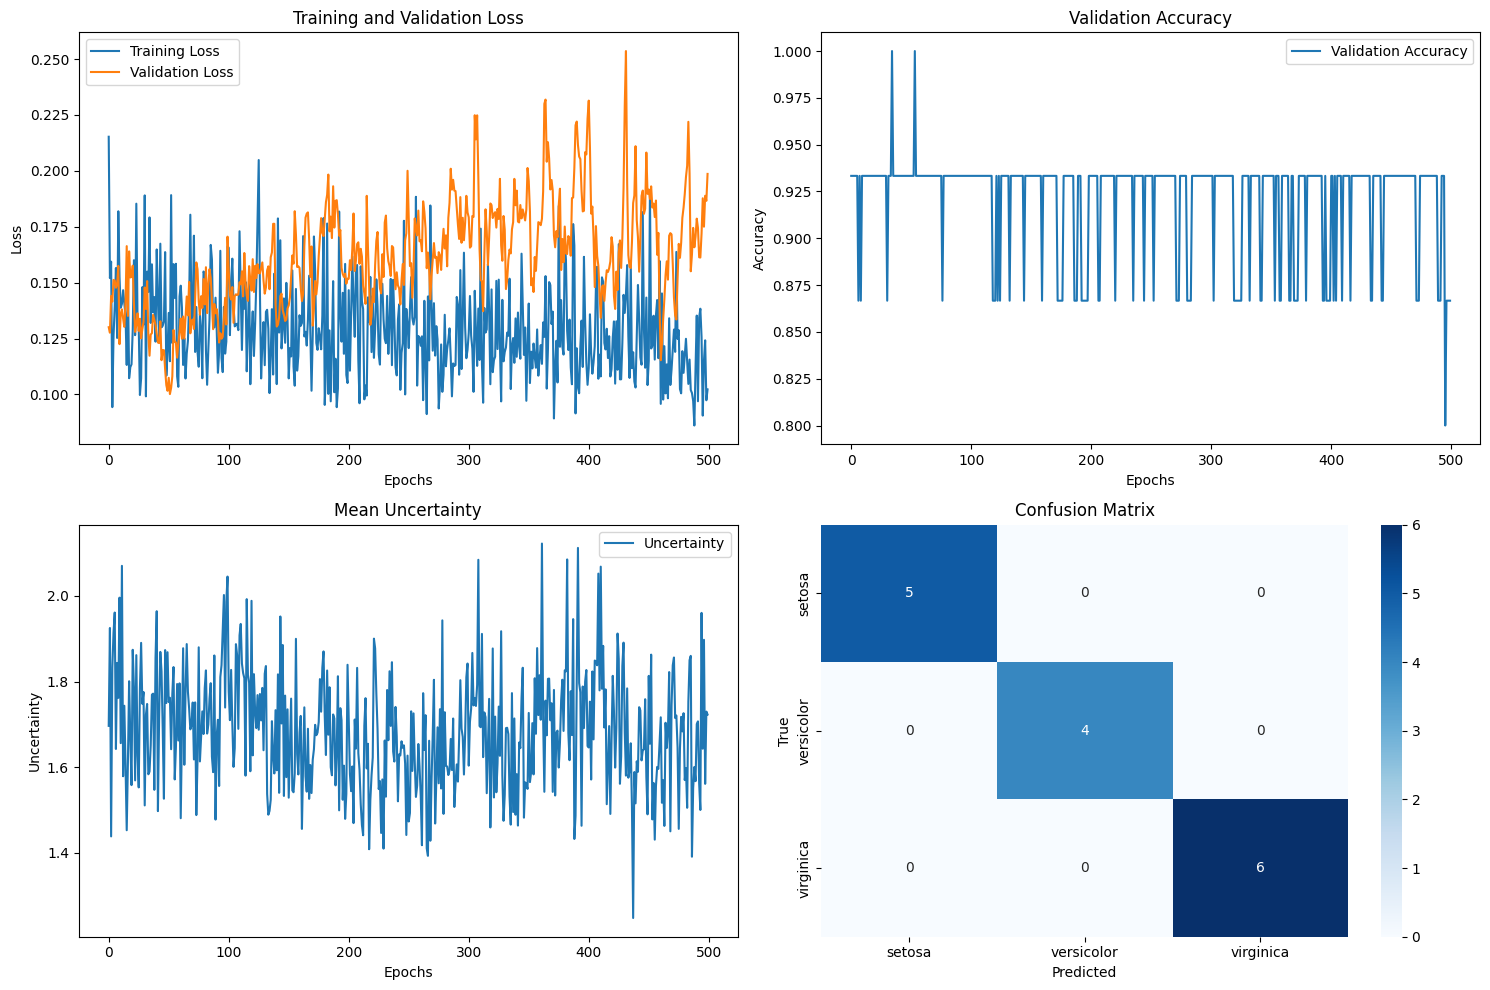

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def train(model, train_loader, val_loader, epochs):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'avg_uncertainty': []  # Теперь точно будем сохранять неопределенность
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        # Training phase
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch, mc_dropout=True)
            
            ce_loss = criterion(outputs, y_batch)
            kl_loss = bkl_loss(model)
            loss = ce_loss + lambda_kl * kl_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        val_loss, val_accuracy, avg_uncertainty = evaluate(model, val_loader)
        
        # Сохраняем все метрики
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['avg_uncertainty'].append(avg_uncertainty)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Uncertainty: {avg_uncertainty:.4f}")
    
    return history

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    uncertainties = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Монте-Карло семплирование для оценки неопределенности
            outputs_list = [model(X_batch, mc_dropout=True) for _ in range(mc_samples_eval)]
            outputs_stack = torch.stack(outputs_list)
            
            outputs_mean = outputs_stack.mean(dim=0)
            outputs_std = outputs_stack.std(dim=0)
            
            loss = criterion(outputs_mean, y_batch)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs_mean.data, 1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)
            
            uncertainties.extend(outputs_std.mean(dim=1).cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    avg_uncertainty = np.mean(uncertainties)
    return avg_loss, accuracy, avg_uncertainty

# Обучаем модель
history = train(model, train_loader, val_loader, epochs=500)

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. График потерь
axes[0, 0].plot(history['train_loss'], label='Training Loss')
axes[0, 0].plot(history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# 2. График точности
axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# 3. График неопределенности
axes[1, 0].plot(history['avg_uncertainty'], label='Uncertainty')
axes[1, 0].set_title('Mean Uncertainty')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Uncertainty')
axes[1, 0].legend()

# 4. Матрица ошибок
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], 
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1, 1].set_title('Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       1.00      1.00      1.00         4
   virginica       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


ROC-AUC Score: 1.0000


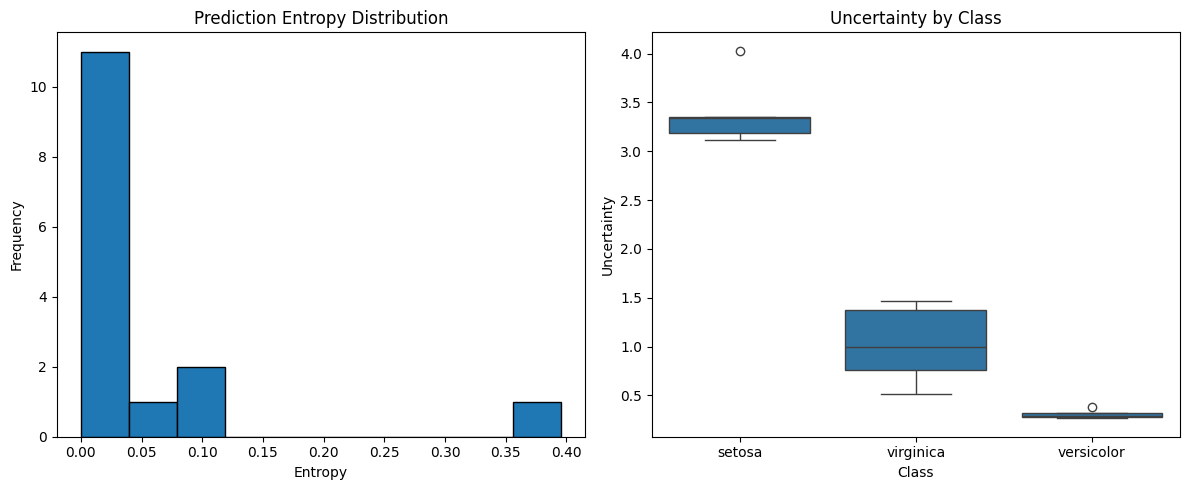


New Sample Prediction:
Class: setosa
Probabilities: {'setosa': 1.0, 'versicolor': 0.0, 'virginica': 0.0}
Uncertainty: 3.9405


In [46]:
# 1. First calculate uncertainties and predicted classes
uncertainties = []
predicted_classes = []
y_true = []
y_pred_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Monte Carlo sampling for uncertainty estimation
        outputs_list = [model(X_batch, mc_dropout=True) for _ in range(20)]  # 20 samples
        outputs_stack = torch.stack(outputs_list)
        
        # Mean and standard deviation
        outputs_mean = outputs_stack.mean(dim=0)
        outputs_std = outputs_stack.std(dim=0)
        
        # Probabilities and predictions
        probs = torch.softmax(outputs_mean, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        # Save results
        uncertainties.extend(outputs_std.mean(dim=1).cpu().numpy())
        predicted_classes.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

# 2. Classification report
print("Classification Report:")
print(classification_report(y_true, predicted_classes, target_names=le.classes_))

# 3. ROC-AUC Score
y_pred_proba = np.array(y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# 4. Uncertainty visualization
plt.figure(figsize=(12, 5))

# Entropy histogram
plt.subplot(1, 2, 1)
entropy = -np.sum(y_pred_proba * np.log(y_pred_proba + 1e-10), axis=1)
plt.hist(entropy, bins=10, edgecolor='k')
plt.title("Prediction Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")

# Uncertainty boxplot by class
plt.subplot(1, 2, 2)
unc_df = pd.DataFrame({
    "Uncertainty": uncertainties,
    "Class": [le.classes_[c] for c in predicted_classes]
})
sns.boxplot(data=unc_df, x="Class", y="Uncertainty")
plt.title("Uncertainty by Class")
plt.tight_layout()
plt.show()

# 5. Prediction for new sample
def predict_iris(model, scaler, features, device='cpu'):
    """Make prediction for new Iris sample"""
    # Scale features
    features_scaled = scaler.transform([features])
    input_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    
    # Monte Carlo prediction
    model.eval()
    with torch.no_grad():
        outputs_list = [model(input_tensor, mc_dropout=True) for _ in range(50)]
        outputs_stack = torch.stack(outputs_list)
        probs = torch.softmax(outputs_stack.mean(dim=0), dim=1).cpu().numpy()[0]
        uncertainty = outputs_stack.std(dim=0).mean().cpu().numpy()
    
    pred_class = np.argmax(probs)
    return le.classes_[pred_class], probs, uncertainty

# Example usage
new_sample = [5.1, 3.5, 1.4, 0.2]  # setosa
class_name, probabilities, uncertainty = predict_iris(model, scaler, new_sample)

print("\nNew Sample Prediction:")
print(f"Class: {class_name}")
print(f"Probabilities: {dict(zip(le.classes_, probabilities.round(4)))}")
print(f"Uncertainty: {uncertainty:.4f}")

In [47]:
def predict_iris_detailed(model, scaler, features, device='cpu'):
    features_scaled = scaler.transform([features])
    input_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs_list = [model(input_tensor, mc_dropout=True) for _ in range(50)]
        outputs_stack = torch.stack(outputs_list)
        
        # Get mean probabilities and per-class std
        probs = torch.softmax(outputs_stack.mean(dim=0), dim=1).cpu().numpy()[0]
        per_class_uncertainty = outputs_stack.std(dim=0).cpu().numpy()[0]
        
        pred_class = np.argmax(probs)
    
    print(f"Predicted Class: {pred_class}")
    print(f"Probabilities: {probs.round(6)}")
    print(f"Per-Class Uncertainty: {per_class_uncertainty.round(6)}")
    print(f"Predicted Species: {le.classes_[pred_class]}")
    print(f"Total Uncertainty: {per_class_uncertainty.mean():.4f}")

# Example usage
predict_iris_detailed(model, scaler, [5.1, 3.5, 1.4, 0.2])

Predicted Class: 0
Probabilities: [1. 0. 0.]
Per-Class Uncertainty: [3.815622 3.2248   2.722684]
Predicted Species: setosa
Total Uncertainty: 3.2544
